Repeat the analyses from 2018-01-02, but includes distance Matrices from Matej.

In [1]:
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import product
import json
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy

# ad-hoc imports
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.adjust_text import adjust_text

%matplotlib inline

In [2]:
path = '../data/robomission/2017_12_30/{entity}.csv'
load_entity = lambda name: pd.read_csv(path.format(entity=name), index_col='id')
tasks = load_entity('tasks')
tasks.head()

,name,level,setting,solution
id,,,,
2,turning-left-and-right,moves,"{""fields"": [[[""b"", []], [""b"", [""M""]], [""b"", []...",lrf
6,tunnel,world,"{""fields"": [[[""b"", []], [""b"", []], [""b"", []], ...",srlslrsff
3,zig-zag,while,"{""fields"": [[[""b"", []], [""b"", []], [""b"", []], ...",W!b{rl}
4,triple-slalom,final-challenge,"{""fields"": [[[""b"", []], [""b"", []], [""b"", []], ...",R3{W!r{rl}f}f
5,diamonds-with-signals,if,"{""fields"": [[[""b"", []], [""b"", []], [""b"", []], ...",W!b{fIy{rl}}


In [3]:
def get_token_counts(solution):
    # caveat: 'r' can be either 'right' or 'red' depending on the context
    nesting = 0
    test = False
    counts = defaultdict(int)
    counts = OrderedDict([
        (token, 0)
        for token in ['shoot', 'repeat', 'while', 'if', 'else',
                      'col', 'pos', 'nest']
    ])
    for token in solution:
        if token == '{':
            nesting += 1
            counts['nest'] = max(nesting, counts['nest'])
            test = False
            continue
        if token == '}':
            nesting -= 1
            continue
        if token == 'W':
            counts['while'] += 1
        if token == 'I':
            counts['if'] += 1
        if token == 'R':
            counts['repeat'] += 1
        if token == 's':
            counts['shoot'] += 1
        if token == '/':
            counts['else'] += 1
        if test and token in 'yrgbk':
            counts['col'] += 1
        if test and token == 'x':
            counts['pos'] += 1
        if token in 'WI':
            test = True
    return counts
            

# task = tasks.loc[20]
# print(task.solution)
# print(get_token_counts(task.solution))

# Raw Features

In [4]:
def canonize(letters):
    # canonize wormhole names
    letters = ['W' if letter in 'XYZ' else letter for letter in letters]
    return letters


def get_letter_counts(statement):
    letters = Counter()
    fields = statement['fields']
    for row in fields:
        for _background, objects in row:
            letters.update(canonize(objects))
    return letters


def get_special_color_count(statement):
    fields = statement['fields']
    colors = set()
    for row in fields:
        for background, _objects in row:
            colors.add(background)
    return len(colors) - 2  # don't count black and blue


def get_features(task):
    statement = json.loads(task.setting)
    solution = task.solution
    #print(statement, '\n*\n', solution)
    # statement features
    letter_counts = get_letter_counts(statement)
    features = OrderedDict([
        (letter, letter_counts[letter])
        for letter in 'AMDW'
    ])
    features['Y'] = get_special_color_count(statement)
    features['limit'] = int('length' in statement)
    features['energy'] = int('energy' in statement)
    # solution features
    token_counts = get_token_counts(solution)
    features.update(token_counts)
    return features


# for task in tasks.itertuples():
#     print(get_features(task))
#     break  
RAW_FEATURES = pd.DataFrame.from_records([
    get_features(task) for task in tasks.itertuples()])
STATEMENT_FEATURES = ['A', 'M', 'D', 'W', 'Y', 'limit', 'energy']
SOLUTION_FEATURES = ['shoot', 'repeat', 'while', 'if', 'else', 'col', 'pos', 'nest']
RAW_FEATURES.head()

,A,M,D,W,Y,limit,energy,shoot,repeat,while,if,else,col,pos,nest
0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12,3,2,0,0,0,0,3,0,0,0,0,0,0,0
2,18,0,0,0,0,1,0,0,0,1,0,0,1,0,1
3,0,0,16,4,2,1,0,0,1,1,0,0,1,0,2
4,14,0,3,0,1,1,0,0,0,1,1,0,2,0,2


# Features normalization

In [5]:
def get_feature_df(which_features='all', transform=None, bias=True):
    """Create a DataFrame with selected and transformed featrues.
    
    Args:
        which_features: {'statement', 'solution', 'all'}
        transform: {'bin', 'log', 'max', 'zscore', 'idf', 'pref', 'regr'}
           - Can be combined, e.g. 'log+idf'.
           - Note that 'none', 'bin', 'log', 'max', 'zscore'
             and their combination are variants of term-frequency;
             see https://en.wikipedia.org/wiki/Tf%E2%80%93idf
             for descriptions.
           - 'idf', 'pref', 'regr' normalize for feature importance
           - Idf is the "common-one": log(N/n), where N
             is the number of all tasks, n is the number of
             tasks containing the feature.
           - 'pref': increase weight for solution features
           - 'regr': regressive weights based on the "most
             difficult features (results in soft max-distance)
    """
    # select features
    feature_names = []
    if which_features in {'statement', 'all'}:
        feature_names += STATEMENT_FEATURES
    if which_features in {'solution', 'all'}:
        feature_names += SOLUTION_FEATURES        
    features = RAW_FEATURES[feature_names].copy()    
    # apply transformations
    which_transforms = transform.split('+') if transform else []
    if 'log' in which_transforms:
        features = features.apply(lambda s: np.log(s + 1))
    if 'bin' in which_transforms:
        features = features.apply(lambda s: 0 + (s > 0))
    if 'zscore' in which_transforms:
        features = features.apply(lambda s: (s - s.mean())/s.std(ddof=0))
    if 'max' in which_transforms:
        features = features.apply(lambda s: s / s.max())
    if 'idf' in which_transforms:
        idf = lambda f: (-1) * np.log((f > 0).mean())
        features = features.apply(lambda f: f * idf(f))
    if 'pref' in which_transforms:
        assert which_features in {'solution', 'all'}
        solution_preference = 5
        for f in ['repeat', 'while', 'if', 'else', 'col', 'pos']:
            features[f] *= solution_preference
    if 'regr' in which_transforms:
        assert which_features in {'solution', 'all'}
        weights = pd.Series(
            {'A': 2, 'Y': 2, 'D': 3, 'M': 3, 'W': 4,
             'energy': 4, 'limit': 4, 'shoot': 5,
             'col': 6, 'pos': 7, 'repeat': 10, 'while': 10,
             'nest': 11, 'if': 11, 'else': 12})
        # the +-1 hack to assign max_weight 1 to tasks without
        # any features
        max_weights = ((features > 0) * (weights-1)).max(axis=1) + 1
        features = (features * weights).divide(max_weights, axis=0)    
    # add bias feature (if a task has all features 0, it has std=0 and correlation is undefined)
    features['bias'] = 1
    return features

# Example:
get_feature_df('statement', 'log+max+idf').head()
# Note that for log+idf is not "good-enough": having many diamonds
# leads to much higher weight than having while-loop. That's why
# "max" transformation is important, and "pref" can help further.
#get_feature_df('all', 'none').head()
#get_feature_df('all', 'log+max+idf+pref').head()
#get_feature_df('all', 'log+max+regr').head()

,A,M,D,W,Y,limit,energy,bias
0,0.332536,0.651297,0.000000,0.000000,0.000000,0.00000,0.0,1
1,0.476034,0.463993,0.116297,0.000000,0.000000,0.00000,0.0,1
2,0.546464,0.000000,0.000000,0.000000,0.000000,0.27996,0.0,1
3,0.000000,0.000000,0.299920,0.391331,0.861468,0.27996,0.0,1
4,0.502593,0.000000,0.146751,0.000000,0.543526,0.27996,0.0,1


# L1 Similarity matrices

In [6]:
def compute_similarity_matrix(feature_df, metric='correlation'):
    """Compute square matrix of distances between columns in feature_df
        (0 = most similar)
    """
    distances = pdist(feature_df.values, metric=metric)
    dist_matrix = squareform(distances)
    return dist_matrix


def get_name(feature_setting, metric):
    name = '{which_features}/{transform}/{metric}'.format(
        metric=metric, **feature_setting)
    return name.lower()


which_features_options = ['statement', 'solution', 'all']
transform_options = [
    'none', 'log', 'bin', 'log+max', 'log+max+idf']
similarity_metrics = ['correlation', 'euclidean']
feature_settings = [
    {'which_features': which_features, 'transform': transform}
    for which_features in which_features_options
    for transform in transform_options
]
feature_settings2 = [
    {'which_features': 'all', 'transform': transform}
    for transform in transform_options \
        + ['log+max+idf+pref', 'log+max+regr', 'log+max+idf+regr']
]

def process_featuers_settings(feature_settings):    
    option_names = [
        get_name(feature_setting, metric)
        for feature_setting in feature_settings
        for metric in similarity_metrics]
    feature_dfs = [
        get_feature_df(**setting)
        for setting in feature_settings]
    similarity_matrices = [
        compute_similarity_matrix(feature_df, metric=metric)
        for feature_df in feature_dfs
        for metric in similarity_metrics]
    similarity_matrices = OrderedDict([
        (name, matrix) for name, matrix
        in zip(option_names, similarity_matrices)])
    return similarity_matrices

similarity_matrices = process_featuers_settings(feature_settings)
print('Computed', len(similarity_matrices), 'similarity matrices.')
similarity_matrices2 = process_featuers_settings(feature_settings2)
print('Computed', len(similarity_matrices2), 'similarity matrices.')

Computed 30 similarity matrices.
Computed 16 similarity matrices.


In [7]:
def show_similarity_matrix(sm):
    linkage = scipy.cluster.hierarchy.linkage(sm, method='average')
    sns.clustermap(sm, row_linkage=linkage, col_linkage=linkage)

### Example: log normalized features, Pearson correlation

/home/xeffenb1/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
/home/xeffenb1/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


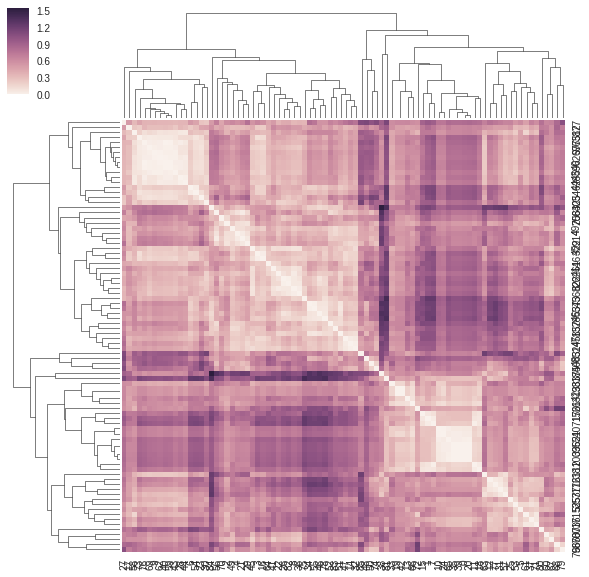

In [8]:
#sns.heatmap(similarity_matrices['all/log/correlation'])
show_similarity_matrix(similarity_matrices['all/log+max/correlation'])
#show_similarity_matrix(similarity_matrices['all/log/euclidean'])

# Include Matej's distance matrices

Adding Bag
Adding Bag_bin
Adding Bag_log
Adding Bag_tfidf
Adding Levenshtein
Adding TED


/home/xeffenb1/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
/home/xeffenb1/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


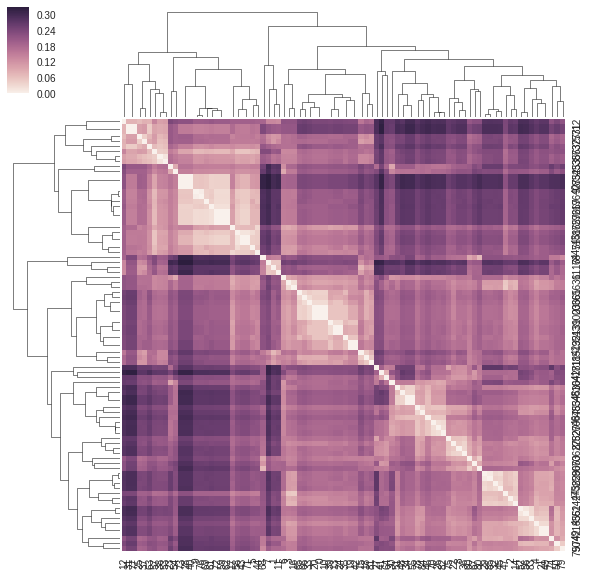

In [43]:
def load_distance_matrix(name):
    path = './distance_matrices/{name}_matrix.csv'
    dm = pd.read_csv(path.format(name=name), index_col='name', sep=';')
    dm = dm.loc[:, 'turning-left-and-right':'diamond-in-house']  # remove last ("unnamed") column
    # Check that the order of tasks in matrices is same in my and Matej's Matrices:
    assert all(dm.index == tasks.name) and all(dm.columns == tasks.name)
    return dm

names = ['Bag', 'Bag_bin', 'Bag_log', 'Bag_tfidf', 'Levenshtein', 'TED']
for name in names:
    print('Adding', name)
    dm = load_distance_matrix(name)
    similarity_matrices[name] = dm.values
    similarity_matrices2[name] = dm.values
    
# Example of similarity matrix heatmap
show_similarity_matrix(similarity_matrices['Bag_tfidf'])

# L2: Agreement between similarity matrices

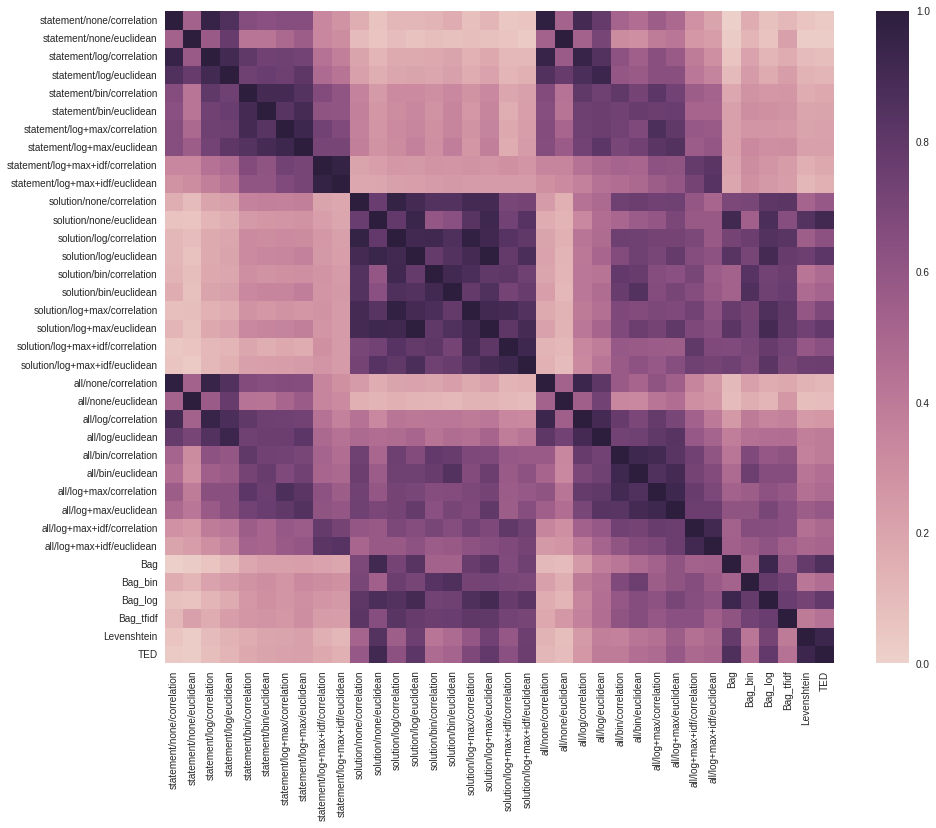

In [44]:
def total_correlation(a, b, method='pearson'):
    a = pd.Series(a.flatten())
    b = pd.Series(b.flatten())
    corr = a.corr(b, method=method)
    return corr


def top_k_agreement(a, b, k=5):
    a = pd.DataFrame(a)
    b = pd.DataFrame(b)
    a_ranks = a.rank(method='first')
    b_ranks = b.rank(method='first')
    a_top = a_ranks <= (k+1)
    b_top = b_ranks <= (k+1)
    ab_top = a_top & b_top
    avg_agreement = ab_top.sum(axis=1).mean() - 1
    return avg_agreement


pearson = partial(total_correlation, method='pearson')
spearman = partial(total_correlation, method='spearman')
top5 = partial(top_k_agreement, k=5)
top10 = partial(top_k_agreement, k=15)


def compute_agreements(agreement_fn, matrices=similarity_matrices):
    labels, matrices_list = matrices.keys(), matrices.values()
    agreements_list = [
        [agreement_fn(a, b) for b in matrices_list]
        for a in matrices_list]
    agreements = pd.DataFrame(
        agreements_list, columns=labels, index=labels)
    return agreements


def compute_agreement_matrix(agreement_fn, matrices=similarity_matrices):
    df = compute_agreements(agreement_fn, matrices)
    return df.values
    

def show_agreement_matrix(agreement_fn, matrices=similarity_matrices):
    agreements = compute_agreements(agreement_fn, matrices)
    plt.figure(figsize=(15, 12))
    cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(agreements, annot=False, cmap=cmap, vmin=0)


show_agreement_matrix(pearson)

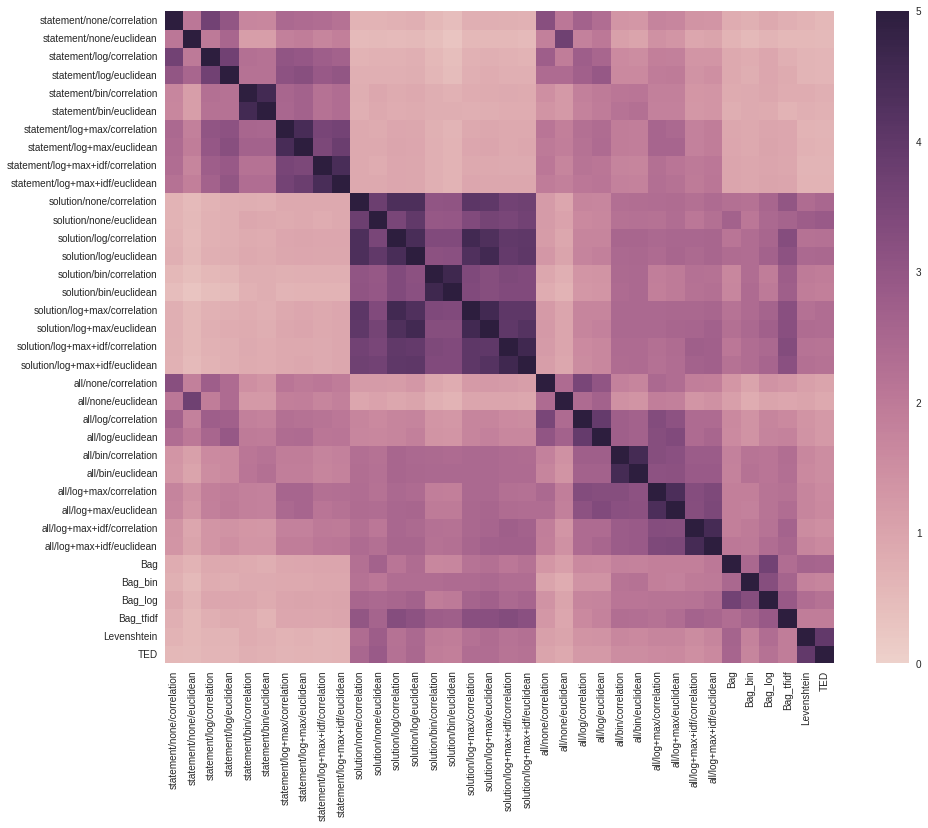

In [45]:
show_agreement_matrix(top5)

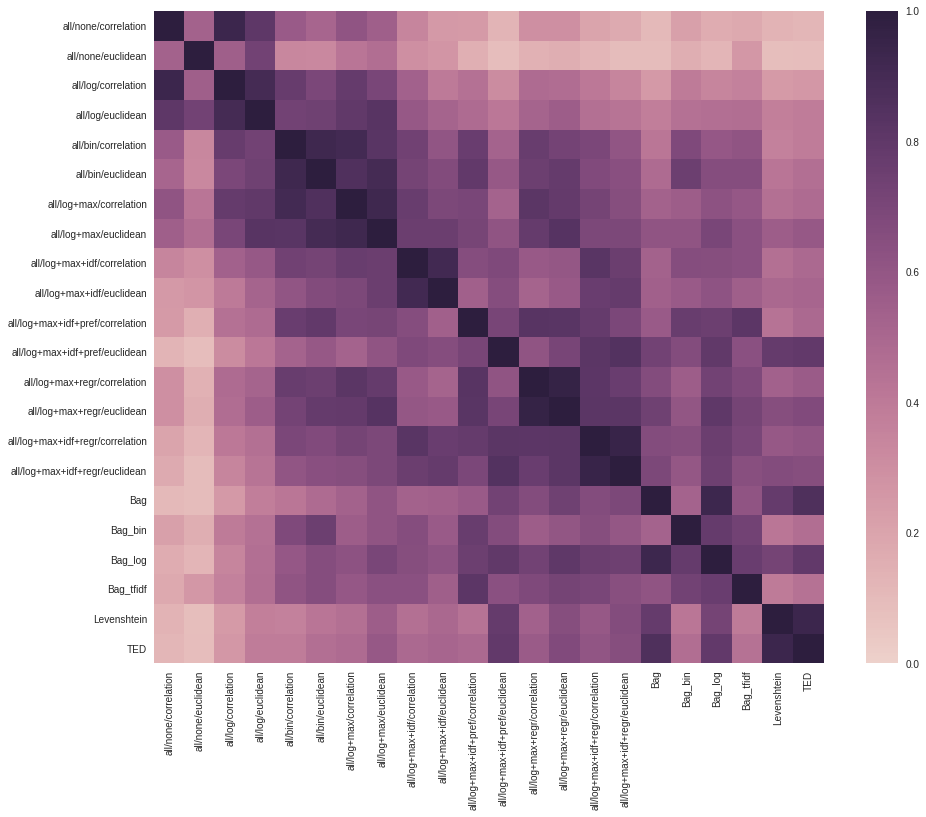

In [46]:
show_agreement_matrix(pearson, matrices=similarity_matrices2)

# L3: Agreement between agreement metrics

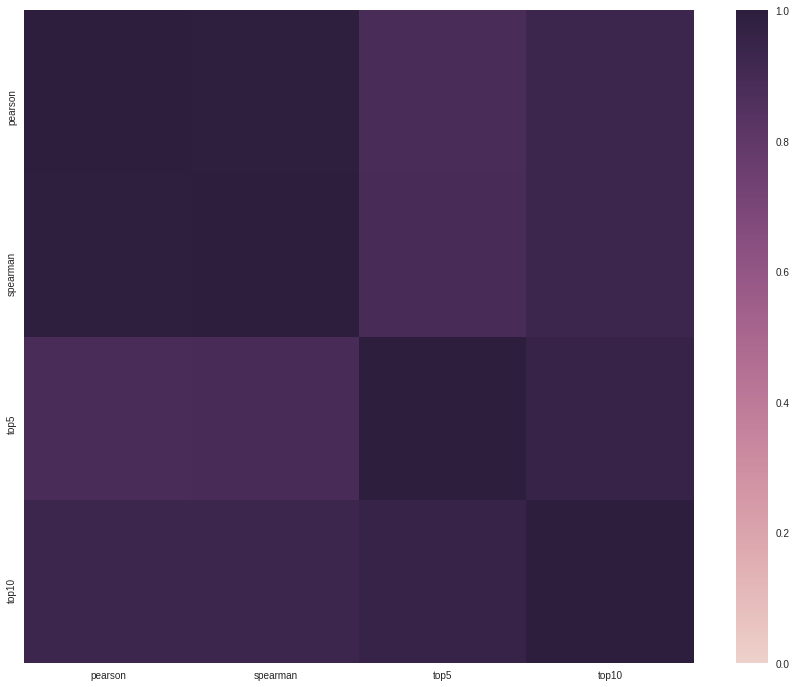

In [47]:
agreement_fns = {
    'pearson': pearson, 'spearman': spearman,
    'top5': top5, 'top10': top10,
}

agreement_matrices = OrderedDict([
    (label, compute_agreement_matrix(agreement_fn))
    for label, agreement_fn in agreement_fns.items()
])

show_agreement_matrix(pearson, agreement_matrices)